## **FantaBayesianNet: a Bayesian Network to make inference on individual performance in football**

***Fundamentals of Artificial Intelligence and Knowledge Representation (Mod. 3) - Alma Mater Studiorum Università di Bologna***

*Authors:*
- Giuseppe	Boezio	(0001005271 $-$ giuseppe.boezio@studio.unibo.it)
- Giuseppe	Murro	(0000997317 $-$ giuseppe.murro@studio.unibo.it)
- Salvatore	Pisciotta	(0000985203 $-$ salvatore.pisciotta2@studio.unibo.it)

### **Abstract**
This notebook explains the work done and the results achieved in the Knowledge Representation class project,
specifically in the module about uncertainty and probabilistic reasoning, held by professor Paolo Torroni.

The task of predicting the performance of football players is gaining increasing
attention in the sports and statistical communities. In this work, we used a Bayesian Network to model relevant factors of player performance in the
presence of noisy data. We apply our analysis to the 2020–2021 season in the top Italian league, Serie A, and use the player ratings provided by a popular Italian fantasy football game, the so-called *Fantacalcio*.

Our central goals are to explore what are the causal relations that allow to predict if a football player can be deployed or not in a fantasy football lineup. Different kind of reasoning are done to exploit the flow of influence between variables and possible independences.

In [1]:
import sys
!{sys.executable} -m pip install pgmpy
!{sys.executable} -m pip install --upgrade pip

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

from pgmpy.estimators import BayesianEstimator
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination

     |████████████████████████████████| 337kB 9.1MB/s 
     |████████████████████████████████| 1.5MB 11.8MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **2. Data preprocessing**
The first step consists in load data, merge different dataframes to get a single dataframe of players and process feature in order to work with them.

We use data collected from [*Fantacalcio.it*](https://www.fantacalcio.it/statistiche-serie-a) and [*Transfermarket.it*](https://www.transfermarkt.it/serie-a/startseite/wettbewerb/IT1). We decided to select only **forwards**, since their statistics are the most interesting from the view point of the *Fantacalcio*, and we picked an average of 2 players per team for a total of 40 players. 

These data are about the first 30 rounds of the 2020–2021 Serie A season.

In [2]:
from google.colab import files
upload = files.upload()

Saving stats_baldé.csv to stats_baldé.csv
Saving stats_barrow.csv to stats_barrow.csv
Saving stats_belotti.csv to stats_belotti.csv
Saving stats_berardi.csv to stats_berardi.csv
Saving stats_caicedo.csv to stats_caicedo.csv
Saving stats_caprari.csv to stats_caprari.csv
Saving stats_caputo.csv to stats_caputo.csv
Saving stats_correa.csv to stats_correa.csv
Saving stats_cristiano_ronaldo.csv to stats_cristiano_ronaldo.csv
Saving stats_destro.csv to stats_destro.csv
Saving stats_dybala.csv to stats_dybala.csv
Saving stats_dzeko.csv to stats_dzeko.csv
Saving stats_gervinho.csv to stats_gervinho.csv
Saving stats_ibrahimovic.csv to stats_ibrahimovic.csv
Saving stats_ilicic.csv to stats_ilicic.csv
Saving stats_immobile.csv to stats_immobile.csv
Saving stats_insigne.csv to stats_insigne.csv
Saving stats_joão_pedro.csv to stats_joão_pedro.csv
Saving stats_kalinic.csv to stats_kalinic.csv
Saving stats_lapadula.csv to stats_lapadula.csv
Saving stats_leão.csv to stats_leão.csv
Saving stats_lozano.

In [3]:
list_file = os.listdir()


list_file.remove('.config')
list_file.remove('sample_data')
#print(list_file)

players = []

for file in list_file:
  players.append(pd.read_csv(file))

df = pd.concat(players)
df

,matchday,date,home_team_pos,home_team,away_team_pos,away_team,result,available,goal,assist,autogoal,yellow_card,double_yellow_card,red_card,substitution_on,substitution_off,minutes,penalty_kicker,home_match,score,grade,penalty_scored,penalty_kick,starter,postponed,difficulty_match,deployability
0,2,27/set/2020,19.0,Roma,5.0,Juventus,2:2,Available,0,0,0,False,False,False,NaN,58.0,58,False,False,5.0,5.0,0,0,True,False,3,False
1,3,07/apr/2021,6.0,Juventus,1.0,Napoli,2:1,Available,0,0,0,False,False,False,NaN,69.0,69,False,True,6.0,NaN,0,0,False,True,2,True
2,4,17/ott/2020,20.0,Crotone,5.0,Juventus,1:1,Available,1,0,0,False,False,False,NaN,NaN,90,False,False,10.5,7.5,0,0,True,False,1,True
3,5,25/ott/2020,5.0,Juventus,7.0,Verona,1:1,Available,0,1,0,False,False,False,NaN,NaN,90,False,True,6.5,6.5,0,0,True,False,2,False
4,6,01/nov/2020,14.0,Spezia,5.0,Juventus,1:4,Available,1,1,0,False,False,False,NaN,78.0,78,False,False,12.0,8.0,0,0,True,False,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,26,06/mar/2021,3.0,Juventus,7.0,Lazio,3:1,Available,0,0,0,False,False,False,NaN,82.0,82,True,False,5.0,5.0,0,0,True,False,4,False
25,27,12/mar/2021,7.0,Lazio,20.0,Crotone,3:2,Available,0,1,0,False,False,False,NaN,76.0,76,True,True,5.0,5.0,0,0,True,False,1,False
26,28,21/mar/2021,NaN,Udinese,NaN,Lazio,0:1,Available,0,0,0,False,False,False,NaN,74.0,74,True,False,6.0,6.0,0,0,True,False,2,False
27,29,03/apr/2021,NaN,Lazio,NaN,Spezia,2:1,Available,0,0,0,False,False,False,NaN,72.0,72,True,True,5.5,5.5,0,0,True,False,2,False


Data cleaning and discretization

In [4]:
# remove postponed matches
df.drop(df[df['postponed'] == True].index, inplace=True)

# change available in True/False
df['available'] = df['available'].apply(lambda x : True if x == 'Available' else False)

# change goal in True/False
df['goal'] = df['goal'].apply(lambda x: True if x > 0 else False)

# change assist in True/False
df['assist'] = df['assist'].apply(lambda x: True if x > 0 else False)

# change minutes into ranges [0-15], [16-45], [46-90]
bins = [0, 16, 46, 95]
labels = ['0-15', '16-45', '46-90']
df['time_range'] = pd.cut(df['minutes'], bins=bins, labels=labels, right=False)

# change scores into sv, [<=5.5], [6-7], [7.5-9], [>=9.5]
df['score'].fillna(value=-5, inplace=True)
bins = [-5, -4, 6, 7.5, 9.5, 25]
labels = ['sv', '<=5.5', '6-7', '7.5-9', '>=9.5']
df['score_range'] = pd.cut(df['score'],  bins=bins, labels=labels, right=False)

# only columns needed
variables = ['penalty_kicker', 'goal', 'assist', 'yellow_card', 'red_card', 'available', 'starter', 'time_range', 'score_range', 'difficulty_match', 'deployability']
df = df[variables]
df

,penalty_kicker,goal,assist,yellow_card,red_card,available,starter,time_range,score_range,difficulty_match,deployability
3,False,False,True,False,False,True,True,46-90,6-7,2,False
4,False,True,True,False,False,True,True,46-90,>=9.5,2,True
5,False,False,False,False,False,True,True,46-90,6-7,3,True
6,False,False,True,False,False,True,True,46-90,6-7,1,False
7,False,True,False,False,True,True,True,46-90,7.5-9,2,True
...,...,...,...,...,...,...,...,...,...,...,...
22,True,False,False,False,False,True,True,46-90,6-7,2,True
24,True,False,False,False,False,True,True,46-90,<=5.5,4,False
25,True,False,True,False,False,True,True,46-90,<=5.5,1,False
26,True,False,False,False,False,True,True,46-90,6-7,2,False


In [5]:
df.dtypes

penalty_kicker          bool
goal                    bool
assist                  bool
yellow_card             bool
red_card                bool
available               bool
starter                 bool
time_range          category
score_range         category
difficulty_match       int64
deployability           bool
dtype: object

Correlation matrix has been used to understand whether flow of influence among variables were meaningful.

In [6]:
# Transforming ordinal variables in order to investigate about them

ordinal_features =['time_range', 'score_range']
ordinal_transformer = OrdinalEncoder(dtype = np.int32)
preprocessor = ColumnTransformer(
    transformers = [
                    ('ord', ordinal_transformer, ordinal_features)
                   ],
                    remainder = 'passthrough'  # with 'passthrough' the non-specified columns in transformers will be automatically passed through                       
    )

preprocessor.fit(df)

df_p = preprocessor.fit_transform(df)
columns= ['time_range', 'score_range', 'penalty_kicker', 'goal', 'assist', 'yellow_card', 'red_card', 'available', 'starter', 'difficulty_match', 'deployability']

# Conversion on dataframe for all players
df_p = pd.DataFrame(df_p, columns=columns).convert_dtypes()

# Checking types
print(df_p.dtypes)

time_range            Int64
score_range           Int64
penalty_kicker      boolean
goal                boolean
assist              boolean
yellow_card         boolean
red_card            boolean
available           boolean
starter             boolean
difficulty_match      Int64
deployability       boolean
dtype: object


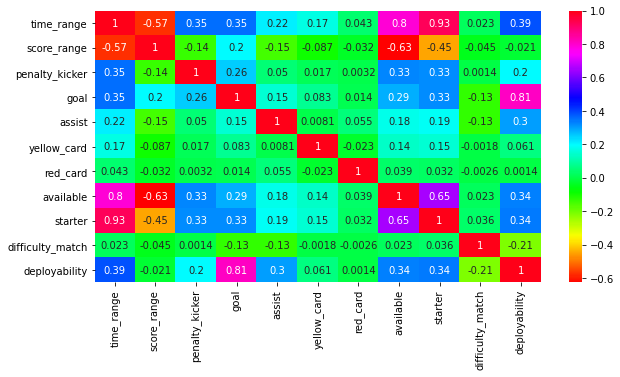

In [7]:
plt.figure(figsize=(10,5))
sns.heatmap(df_p.corr(), annot=True, cmap='hsv')
plt.show()

Show histograms for all varibles in the dataset to understand their distribution

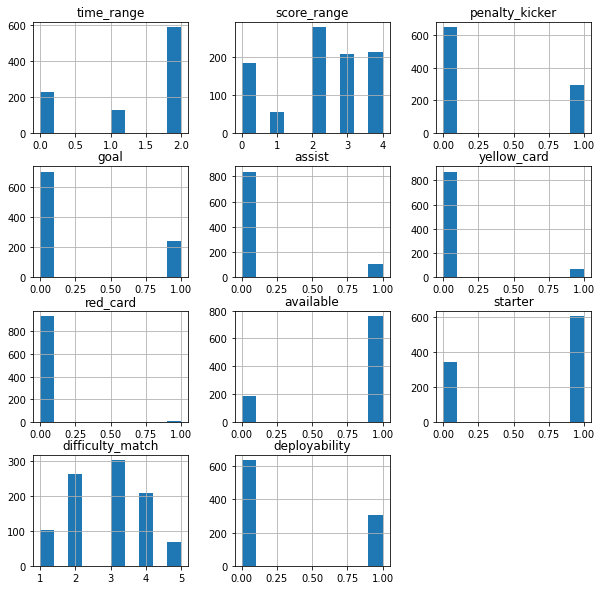

In [8]:
pd.DataFrame.hist(df_p.astype('int')
                  , figsize = [10,10]
                 );

### **3. Define the model**
The second step consists in building the structure of our model, that is to define the relations between the involved variables.
In the following lines we define the network model using pgmpy library and then we display the resulting graph using networkx.

In [9]:
model = BayesianModel([('available', 'starter'),
                       ('starter', 'time_range'),
                       ('time_range', 'red_card'),
                       ('time_range', 'yellow_card'),
                       ('time_range', 'goal'),
                       ('time_range', 'assist'),
                       ('available', 'penalty_kicker'),
                       ('penalty_kicker', 'goal'),
                       ('red_card', 'score_range'),
                       ('yellow_card', 'score_range'),
                       ('goal', 'score_range'),
                       ('assist', 'score_range'),
                       ('difficulty_match', 'deployability'),
                       ('score_range', 'deployability')
                       ])

#Network nodes and out-edges
nodes = list(model.nodes())
edges = list(model.edges())
print("Nodes:", nodes)
print("\nOutEdges:", edges)

Nodes: ['available', 'starter', 'time_range', 'red_card', 'yellow_card', 'goal', 'assist', 'penalty_kicker', 'score_range', 'difficulty_match', 'deployability']

OutEdges: [('available', 'starter'), ('available', 'penalty_kicker'), ('starter', 'time_range'), ('time_range', 'red_card'), ('time_range', 'yellow_card'), ('time_range', 'goal'), ('time_range', 'assist'), ('red_card', 'score_range'), ('yellow_card', 'score_range'), ('goal', 'score_range'), ('assist', 'score_range'), ('penalty_kicker', 'goal'), ('score_range', 'deployability'), ('difficulty_match', 'deployability')]


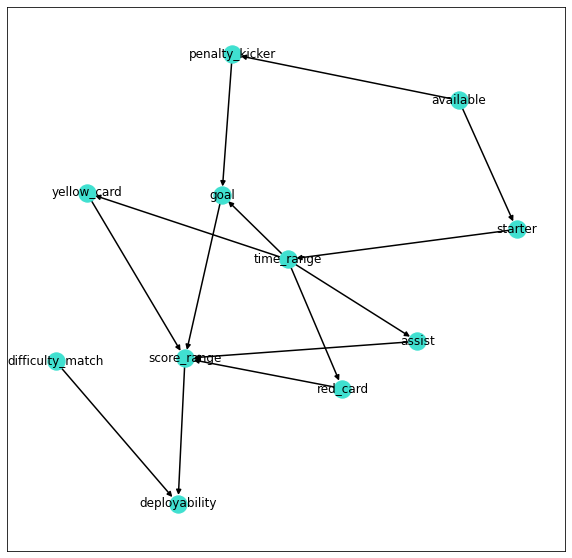

In [10]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
%matplotlib inline
np.random.seed(8)

DAG = nx.DiGraph()
DAG.add_edges_from(edges)

fig = plt.figure(figsize = (10,10))
pos = nx.spring_layout(DAG) #Position nodes computed by using Fruchterman-Reingold force-directed algorithm.
nx.draw_networkx_nodes(DAG, pos=pos, node_color='turquoise')
nx.draw_networkx_labels(DAG, pos=pos)
nx.draw_networkx_edges(DAG, pos=pos, edge_color='black', width = 1.5, arrows=True)
plt.show()

# 

### **4. Learning of network parameters**
In pgmpy it is possible to learn the CPT of a given Bayesian network using either a Bayesian Estimator or a Maximum Likelihood Estimator (MLE). The former exploits a known prior distribution of data, the latter does not make any particular assumption.

MLE can overfit the data in case of small datasets, because there can be not enough observations and thus the observed frequencies can be not representative. Another problem with MLE is the fact that state counts are done conditionally for each parents configuration and this causes immense fragmentation since the state counts drop even more. The Bayesian estimator instead does not only rely on input data to learn the network parameters, but it also takes advantage of a prior knowledge, expressed through a prior distribution. In this way, the estimator does not have an absolute guide, but rather a reasonable starting assumption that allows to counterbalance the lack of data.

Although the MLE approach seems plausible, it can be overly simplistic in many cases, whereas the Bayesian one is intrinsically more robust. As a consequence the Bayesian estimator is choosen.

There are several prior distribuitions available in pgmpy, a sensible choice of prior is the Bayesian Dirichlet equivalent uniform prior (BDeu). In the learning process, using BDeu, N uniform samples are generated for each variable to compute the pseudo-counts (default is N=5), hence the estimated probabilities in CPT are more conservative than the ones obtained through MLE (i.e. probabilities close to 1 or 0 get smoothed).

In the following cell the CPT are learned and displayed.

In [11]:
from IPython.core.display import display, HTML

# disable text wrapping in output cell
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

model.cpds = []
model.fit(  data=df
          , estimator=BayesianEstimator
          , prior_type="BDeu"
          , equivalent_sample_size=10
          ,complete_samples_only=False)

print(f'Check model: {model.check_model()}\n')
for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')


Check model: True

CPT of available:
+------------------+----------+
| available(False) | 0.196017 |
+------------------+----------+
| available(True)  | 0.803983 |
+------------------+----------+ 

CPT of starter:
+----------------+----------------------+---------------------+
| available      | available(False)     | available(True)     |
+----------------+----------------------+---------------------+
| starter(False) | 0.9866310160427807   | 0.20795306388526727 |
+----------------+----------------------+---------------------+
| starter(True)  | 0.013368983957219251 | 0.7920469361147328  |
+----------------+----------------------+---------------------+ 

CPT of time_range:
+-------------------+----------------------+----------------------+
| starter           | starter(False)       | starter(True)        |
+-------------------+----------------------+----------------------+
| time_range(0-15)  | 0.6676356589147286   | 0.00273224043715847  |
+-------------------+----------------------+

### **5. Markov blanket**

-------------------------------------------------------------------------------- 

available 
Markov blanket -> ['starter', 'penalty_kicker']


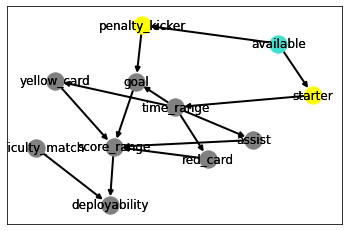

-------------------------------------------------------------------------------- 

starter 
Markov blanket -> ['time_range', 'available']


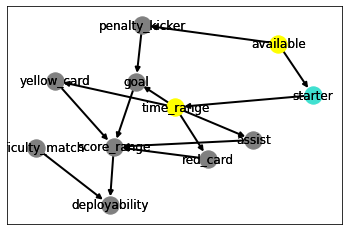

-------------------------------------------------------------------------------- 

time_range 
Markov blanket -> ['starter', 'yellow_card', 'goal', 'penalty_kicker', 'red_card', 'assist']


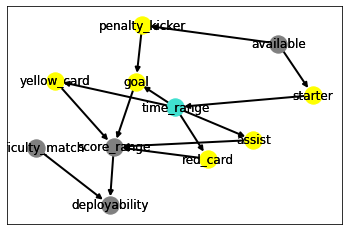

-------------------------------------------------------------------------------- 

red_card 
Markov blanket -> ['yellow_card', 'goal', 'score_range', 'time_range', 'assist']


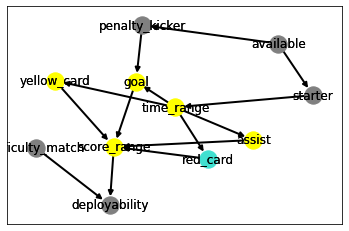

-------------------------------------------------------------------------------- 

yellow_card 
Markov blanket -> ['goal', 'score_range', 'time_range', 'red_card', 'assist']


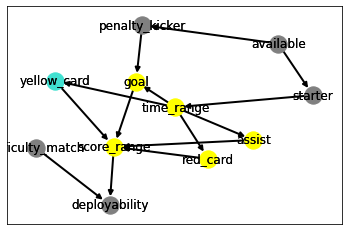

-------------------------------------------------------------------------------- 

goal 
Markov blanket -> ['yellow_card', 'score_range', 'penalty_kicker', 'time_range', 'red_card', 'assist']


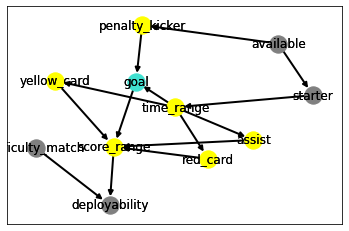

-------------------------------------------------------------------------------- 

assist 
Markov blanket -> ['yellow_card', 'goal', 'score_range', 'time_range', 'red_card']


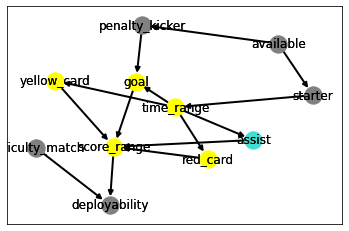

-------------------------------------------------------------------------------- 

penalty_kicker 
Markov blanket -> ['available', 'time_range', 'goal']


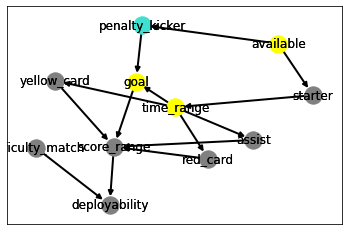

-------------------------------------------------------------------------------- 

score_range 
Markov blanket -> ['yellow_card', 'goal', 'deployability', 'difficulty_match', 'red_card', 'assist']


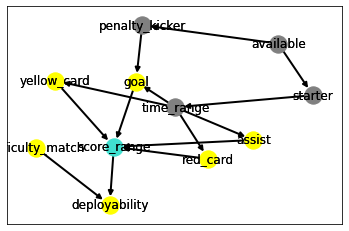

-------------------------------------------------------------------------------- 

difficulty_match 
Markov blanket -> ['deployability', 'score_range']


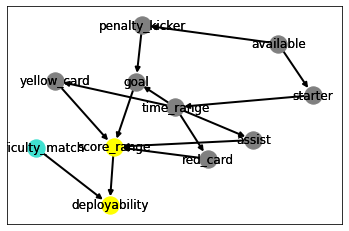

In [12]:
leaves = model.get_leaves()
markov_blanket = {}

for node in nodes:
    if not node in leaves:
        markov_blanket[node] = model.get_markov_blanket(node)
        print("-"*80,"\n")
        print(node, "\nMarkov blanket ->", markov_blanket[node])
        
        nx.draw_networkx_nodes(DAG, pos, nodelist=[node], node_color='turquoise')
        nx.draw_networkx_nodes(DAG, pos, nodelist=markov_blanket[node], node_color='yellow')
        nx.draw_networkx_nodes(DAG, pos, 
               nodelist = [n for n in nodes if n not in markov_blanket[node] and n != node], 
               node_color='grey')
        nx.draw_networkx_labels(DAG, pos)
        nx.draw_networkx_labels(DAG, pos)
        nx.draw_networkx_edges(DAG, pos, edge_color='black', width = 2.0, arrows=True)
        plt.show()

### **6. Local semantics**

In [13]:
# Each node is independent from all non descendants given its parents
model.local_independencies(nodes)

(available ⟂ difficulty_match)
(starter ⟂ difficulty_match, penalty_kicker | available)
(time_range ⟂ difficulty_match, available, penalty_kicker | starter)
(red_card ⟂ starter, yellow_card, available, goal, difficulty_match, assist, penalty_kicker | time_range)
(yellow_card ⟂ starter, available, goal, difficulty_match, red_card, assist, penalty_kicker | time_range)
(goal ⟂ starter, yellow_card, available, difficulty_match, red_card, assist | time_range, penalty_kicker)
(assist ⟂ starter, yellow_card, available, goal, difficulty_match, red_card, penalty_kicker | time_range)
(penalty_kicker ⟂ starter, yellow_card, time_range, difficulty_match, red_card, assist | available)
(score_range ⟂ starter, available, time_range, difficulty_match, penalty_kicker | assist, yellow_card, red_card, goal)
(difficulty_match ⟂ starter, yellow_card, score_range, goal, penalty_kicker, available, time_range, red_card, assist)
(deployability ⟂ starter, yellow_card, goal, penalty_kicker, available, time_range

### **7. Exact Inference with Variable Elimination**

In [14]:
inference = VariableElimination(model)

#Possible evidential reasoning
#1
print(" P(score_range|deployability=True)")
print(inference.query(['score_range']
                      ,{'deployability': True}
                      ))

# Probability that the player has made a goal given a score range 6-7 and how this probability
# can be influenced by the fact that he has taken a yellow card (intercausal reasoning)

print("\nP(goal|score_range = 7.5-9)")
print(inference.query(['goal']
                      ,{'score_range': '7.5-9'}
                      ))
#2
print(" P(goal|score_range = 7.5-9,yellow_card = True)")
print(inference.query(['goal']
                      ,{'score_range': '7.5-9', 'yellow_card':True}
                      ))

# Causal reasoning reasoning P(deployability|yellow_card) and P(deployability|yellow_card,goal)

print(" P(deployability|yellow_card)")
print(inference.query(['deployability']
                      ,{'yellow_card': True}
                      ))

#3
print(" P(deployability|yellow_card,goal)")
print(inference.query(['deployability']
                      ,{'yellow_card':True, 'goal':True}
                      ))

#Reasoning about penalty_kicker node
print(" P(goal|penalty_kicker, starter)")
print(inference.query(['goal']
                      ,{'penalty_kicker':True, 'starter':True}
                      ))


print(" P(goal|starter)")
print(inference.query(['goal']
                      ,{'starter':True}
                      ))

#Reasoning about what influence the score_range(va approfondito con nuovi valori)
print(" P(goal|score_range='>=9.5')")
print(inference.query(['goal']
                      ,{'score_range': '>=9.5'}
                      ))

print(" P(goal|score_range='6-7')")
print(inference.query(['goal']
                      ,{'score_range': '6-7'}
                      ))

print(" P(goal,yellow_card|score_range='<=5.5')")
print(inference.query(['goal','yellow_card']
                      ,{'score_range': '<=5.5'}
                      ))




Eliminating: deployability:   0%|          | 0/9 [00:00<?, ?it/s]

 P(score_range|deployability=True)
+--------------------+--------------------+
| score_range        |   phi(score_range) |
+====================+====================+
| score_range(6-7)   |             0.1880 |
+--------------------+--------------------+
| score_range(7.5-9) |             0.1492 |
+--------------------+--------------------+
| score_range(<=5.5) |             0.0034 |
+--------------------+--------------------+
| score_range(>=9.5) |             0.6562 |
+--------------------+--------------------+
| score_range(sv)    |             0.0031 |
+--------------------+--------------------+

P(goal|score_range = 7.5-9)


Eliminating: score_range:   0%|          | 0/9 [00:00<?, ?it/s]

+-------------+-------------+
| goal        |   phi(goal) |
+=============+=============+
| goal(False) |      0.5361 |
+-------------+-------------+
| goal(True)  |      0.4639 |
+-------------+-------------+
 P(goal|score_range = 7.5-9,yellow_card = True)
+-------------+-------------+
| goal        |   phi(goal) |
+=============+=============+
| goal(False) |      0.2780 |
+-------------+-------------+
| goal(True)  |      0.7220 |
+-------------+-------------+
 P(deployability|yellow_card)


Eliminating: score_range:   0%|          | 0/8 [00:00<?, ?it/s]

+----------------------+----------------------+
| deployability        |   phi(deployability) |
+======================+======================+
| deployability(False) |               0.6161 |
+----------------------+----------------------+
| deployability(True)  |               0.3839 |
+----------------------+----------------------+
 P(deployability|yellow_card,goal)
+----------------------+----------------------+
| deployability        |   phi(deployability) |
+======================+======================+
| deployability(False) |               0.1190 |
+----------------------+----------------------+
| deployability(True)  |               0.8810 |
+----------------------+----------------------+
 P(goal|penalty_kicker, starter)


Eliminating: time_range: 100%|██████████| 9/9 [00:00<00:00, 79.96it/s]


+-------------+-------------+
| goal        |   phi(goal) |
+=============+=============+
| goal(False) |      0.5410 |
+-------------+-------------+
| goal(True)  |      0.4590 |
+-------------+-------------+
 P(goal|starter)
+-------------+-------------+
| goal        |   phi(goal) |
+=============+=============+
| goal(False) |      0.6417 |
+-------------+-------------+
| goal(True)  |      0.3583 |
+-------------+-------------+
 P(goal|score_range='>=9.5')


Finding Elimination Order: : 100%|██████████| 8/8 [00:00<00:00, 1680.16it/s]

+-------------+-------------+
| goal        |   phi(goal) |
+=============+=============+
| goal(False) |      0.0109 |
+-------------+-------------+
| goal(True)  |      0.9891 |
+-------------+-------------+
 P(goal|score_range='6-7')
+-------------+-------------+
| goal        |   phi(goal) |
+=============+=============+
| goal(False) |      0.9697 |
+-------------+-------------+
| goal(True)  |      0.0303 |
+-------------+-------------+
 P(goal,yellow_card|score_range='<=5.5')



Eliminating: time_range: 100%|██████████| 8/8 [00:00<00:00, 201.91it/s]

+--------------------+-------------+-------------------------+
| yellow_card        | goal        |   phi(yellow_card,goal) |
+====================+=============+=========================+
| yellow_card(False) | goal(False) |                  0.8689 |
+--------------------+-------------+-------------------------+
| yellow_card(False) | goal(True)  |                  0.0054 |
+--------------------+-------------+-------------------------+
| yellow_card(True)  | goal(False) |                  0.1248 |
+--------------------+-------------+-------------------------+
| yellow_card(True)  | goal(True)  |                  0.0010 |
+--------------------+-------------+-------------------------+


###  **8. Approximate Inference : rejection sampling and likelihood weighting**

In [21]:
from pgmpy.factors.discrete import State
from pgmpy.sampling import BayesianModelSampling

#likelihoodWeighting
def prob_LW(samples,variable):
    return round(np.sum(np.dot(samples[variable],samples['_weight']))/np.sum(samples['_weight']),2)

#Relative error function
def relative_error(exact_value,approx_value):
    return np.absolute((exact_value-approx_value)/exact_value)

#Absolute error function
def absolute_error(exact_value,approx_value):
    return np.absolute(exact_value-approx_value)

def extract_info(query_variables,query_dictionary,value):
  query = inference.query(query_variables,query_dictionary)
  evidence = []

  for (node, value) in query_dictionary.items():
    state = State(node,value)
    evidence.append(state)

  dict={True:1,False:0}
  pquery= query.values[dict[value]]
  variables = query_variables[0]

  return pquery,evidence,variables

#Function for sampling
def run_experiment(sample_size,query_variables,query_dictionary,value):

  inferenceSampling = BayesianModelSampling(model)

  #Flag for printing
  flag = True
  #Rounding precision
  precision = 3

  pquery,query_evidence,var = extract_info(query_variables,query_dictionary,value)

  samples_LW = inferenceSampling.likelihood_weighted_sample(evidence = query_evidence, size=sample_size, return_type='recarray')
  samples_RS = inferenceSampling.rejection_sample(evidence=query_evidence, size=sample_size, return_type='recarray')

  
  pquery_LW = prob_LW(samples_LW,var)
  pquery_RS = np.recarray.mean(samples_RS[var], axis=0)


  # Reporting
  if(flag):
    print()
    print("P({}={}|{}) ={}".format(var,value,query_dictionary,round(pquery,precision)))
    print("With Rejection Sampling after %d samples: %.3f (error = %.2f percent)" 
          % (sample_size, pquery_RS, absolute_error(pquery,pquery_RS)*100))
    print("With Likelihood Weighting after %d samples: %.3f (error = %.2f percent)" 
          % (sample_size, pquery_LW, absolute_error(pquery,pquery_LW)*100))
      
  # Return results
  return np.array([(sample_size, 
                        pquery_RS, absolute_error(pquery,pquery_RS),
                        pquery_LW, absolute_error(pquery,pquery_LW))],
                      dtype=[('sample_size', '<i8'),  
                            ('pquery_RS', '<f8'),('e_pquery_RS', '<f8'),
                            ('pquery_LW', '<f8'),('e_pquery_LW', '<f8')])
  

In [22]:
#Query in exact inference
query_var = ['deployability']
query_dict = {'yellow_card':True}
value=True

results = np.array([],dtype=[('sample_size', '<i8'), 
                             ('pquery_RS', '<f8'),('e_pquery_RS', '<f8'),
                             ('pquery_LW', '<f8'),('e_pquery_LW', '<f8')])

starting_size_=1 # from 10 sample points
final_size=4     # to 10^5 sample points
experiments=20 # 8 experiments

for size in np.logspace(starting_size_, final_size, num=experiments, dtype='<i8'):
    results=np.append(results,run_experiment(size,query_var,query_dict,True))
    
print(results)

Eliminating: time_range: 100%|██████████| 9/9 [00:00<00:00, 91.25it/s]
/usr/local/lib/python3.7/dist-packages/pgmpy/factors/discrete/DiscreteFactor.py:519: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Generating for node: deployability: 100%|██████████| 11/11 [00:00<00:00, 42.77it/s]
122it [00:00, 331.11it/s]
Eliminating: time_range: 100%|██████████| 9/9 [00:00<00:00, 76.43it/s]



P(deployability=True|{'yellow_card': True}) =0.384
With Rejection Sampling after 10 samples: 0.400 (error = 1.61 percent)
With Likelihood Weighting after 10 samples: 0.170 (error = 21.39 percent)


Generating for node: deployability: 100%|██████████| 11/11 [00:00<00:00, 141.27it/s]

Generating for node: deployability: 100%|██████████| 11/11 [00:00<00:00, 43.90it/s]
168it [00:00, 487.84it/s]
Eliminating: time_range: 100%|██████████| 9/9 [00:00<00:00, 68.85it/s]



P(deployability=True|{'yellow_card': True}) =0.384
With Rejection Sampling after 14 samples: 0.571 (error = 18.75 percent)
With Likelihood Weighting after 14 samples: 0.290 (error = 9.39 percent)


Generating for node: deployability: 100%|██████████| 11/11 [00:00<00:00, 124.42it/s]
22it [00:00, 64.58it/s]                        
Eliminating: goal:   0%|          | 0/9 [00:00<?, ?it/s]   


P(deployability=True|{'yellow_card': True}) =0.384
With Rejection Sampling after 20 samples: 0.400 (error = 1.61 percent)
With Likelihood Weighting after 20 samples: 0.240 (error = 14.39 percent)


Generating for node: deployability: 100%|██████████| 11/11 [00:00<00:00, 87.76it/s]
39it [00:00, 155.46it/s]
Eliminating: available:  56%|█████▌    | 5/9 [00:00<00:00, 45.26it/s]


P(deployability=True|{'yellow_card': True}) =0.384
With Rejection Sampling after 29 samples: 0.345 (error = 3.91 percent)
With Likelihood Weighting after 29 samples: 0.500 (error = 11.61 percent)


Generating for node: deployability: 100%|██████████| 11/11 [00:00<00:00, 38.83it/s]
54it [00:00, 126.89it/s]
  0%|          | 0/11 [00:00<?, ?it/s]


P(deployability=True|{'yellow_card': True}) =0.384
With Rejection Sampling after 42 samples: 0.476 (error = 9.22 percent)
With Likelihood Weighting after 42 samples: 0.400 (error = 1.61 percent)



Generating for node: deployability: 100%|██████████| 11/11 [00:00<00:00, 49.20it/s]
80it [00:00, 175.25it/s]
Eliminating: difficulty_match:  56%|█████▌    | 5/9 [00:00<00:00, 48.92it/s]


P(deployability=True|{'yellow_card': True}) =0.384
With Rejection Sampling after 61 samples: 0.311 (error = 7.25 percent)
With Likelihood Weighting after 61 samples: 0.350 (error = 3.39 percent)


Generating for node: deployability: 100%|██████████| 11/11 [00:00<00:00, 34.05it/s]
141it [00:00, 297.70it/s]
Eliminating: time_range: 100%|██████████| 9/9 [00:00<00:00, 68.18it/s]



P(deployability=True|{'yellow_card': True}) =0.384
With Rejection Sampling after 88 samples: 0.386 (error = 0.24 percent)
With Likelihood Weighting after 88 samples: 0.350 (error = 3.39 percent)


Generating for node: deployability: 100%|██████████| 11/11 [00:00<00:00, 43.63it/s]
146it [00:00, 366.74it/s]
Eliminating: assist:  56%|█████▌    | 5/9 [00:00<00:00, 47.85it/s]  


P(deployability=True|{'yellow_card': True}) =0.384
With Rejection Sampling after 127 samples: 0.331 (error = 5.32 percent)
With Likelihood Weighting after 127 samples: 0.310 (error = 7.39 percent)


Generating for node: deployability: 100%|██████████| 11/11 [00:00<00:00, 34.44it/s]
250it [00:00, 520.04it/s]
Eliminating: time_range: 100%|██████████| 9/9 [00:00<00:00, 76.16it/s]



P(deployability=True|{'yellow_card': True}) =0.384
With Rejection Sampling after 183 samples: 0.415 (error = 3.14 percent)
With Likelihood Weighting after 183 samples: 0.380 (error = 0.39 percent)


Generating for node: deployability: 100%|██████████| 11/11 [00:00<00:00, 30.86it/s]
345it [00:00, 677.83it/s]
Eliminating: time_range: 100%|██████████| 9/9 [00:00<00:00, 67.86it/s]



P(deployability=True|{'yellow_card': True}) =0.384
With Rejection Sampling after 263 samples: 0.422 (error = 3.81 percent)
With Likelihood Weighting after 263 samples: 0.340 (error = 4.39 percent)


Generating for node: deployability: 100%|██████████| 11/11 [00:00<00:00, 31.82it/s]
478it [00:00, 849.58it/s]
Eliminating: time_range: 100%|██████████| 9/9 [00:00<00:00, 76.76it/s]



P(deployability=True|{'yellow_card': True}) =0.384
With Rejection Sampling after 379 samples: 0.375 (error = 0.93 percent)
With Likelihood Weighting after 379 samples: 0.350 (error = 3.39 percent)


Generating for node: deployability: 100%|██████████| 11/11 [00:00<00:00, 24.49it/s]
703it [00:00, 1041.66it/s]
Eliminating: time_range: 100%|██████████| 9/9 [00:00<00:00, 83.22it/s]



P(deployability=True|{'yellow_card': True}) =0.384
With Rejection Sampling after 545 samples: 0.393 (error = 0.87 percent)
With Likelihood Weighting after 545 samples: 0.380 (error = 0.39 percent)


Generating for node: deployability: 100%|██████████| 11/11 [00:00<00:00, 18.31it/s]
1010it [00:00, 1278.00it/s]
Eliminating: time_range: 100%|██████████| 9/9 [00:00<00:00, 84.86it/s]



P(deployability=True|{'yellow_card': True}) =0.384
With Rejection Sampling after 784 samples: 0.362 (error = 2.17 percent)
With Likelihood Weighting after 784 samples: 0.380 (error = 0.39 percent)


Generating for node: deployability: 100%|██████████| 11/11 [00:00<00:00, 13.94it/s]
1670it [00:01, 1540.69it/s]
Eliminating: time_range: 100%|██████████| 9/9 [00:00<00:00, 73.88it/s]



P(deployability=True|{'yellow_card': True}) =0.384
With Rejection Sampling after 1128 samples: 0.390 (error = 0.61 percent)
With Likelihood Weighting after 1128 samples: 0.380 (error = 0.39 percent)


Generating for node: deployability: 100%|██████████| 11/11 [00:01<00:00, 10.20it/s]
2315it [00:01, 1694.16it/s]
Eliminating: time_range: 100%|██████████| 9/9 [00:00<00:00, 73.56it/s]



P(deployability=True|{'yellow_card': True}) =0.384
With Rejection Sampling after 1623 samples: 0.378 (error = 0.56 percent)
With Likelihood Weighting after 1623 samples: 0.380 (error = 0.39 percent)


Generating for node: deployability: 100%|██████████| 11/11 [00:01<00:00,  7.16it/s]
3584it [00:01, 1875.19it/s]
Eliminating: time_range: 100%|██████████| 9/9 [00:00<00:00, 76.80it/s]



P(deployability=True|{'yellow_card': True}) =0.384
With Rejection Sampling after 2335 samples: 0.373 (error = 1.14 percent)
With Likelihood Weighting after 2335 samples: 0.400 (error = 1.61 percent)


Generating for node: deployability: 100%|██████████| 11/11 [00:01<00:00,  5.68it/s]
4927it [00:02, 2115.08it/s]
Eliminating: time_range: 100%|██████████| 9/9 [00:00<00:00, 78.07it/s]



P(deployability=True|{'yellow_card': True}) =0.384
With Rejection Sampling after 3359 samples: 0.386 (error = 0.19 percent)
With Likelihood Weighting after 3359 samples: 0.390 (error = 0.61 percent)


Generating for node: deployability: 100%|██████████| 11/11 [00:02<00:00,  4.06it/s]
7034it [00:03, 2169.03it/s]
Eliminating: time_range: 100%|██████████| 9/9 [00:00<00:00, 66.72it/s]


P(deployability=True|{'yellow_card': True}) =0.384
With Rejection Sampling after 4832 samples: 0.381 (error = 0.34 percent)
With Likelihood Weighting after 4832 samples: 0.390 (error = 0.61 percent)



Generating for node: deployability: 100%|██████████| 11/11 [00:03<00:00,  2.97it/s]
10004it [00:04, 2302.82it/s]
Eliminating: time_range: 100%|██████████| 9/9 [00:00<00:00, 72.02it/s]



P(deployability=True|{'yellow_card': True}) =0.384
With Rejection Sampling after 6951 samples: 0.380 (error = 0.44 percent)
With Likelihood Weighting after 6951 samples: 0.380 (error = 0.39 percent)


Generating for node: deployability: 100%|██████████| 11/11 [00:05<00:00,  2.14it/s]
13917it [00:05, 2358.36it/s]


P(deployability=True|{'yellow_card': True}) =0.384
With Rejection Sampling after 10000 samples: 0.386 (error = 0.22 percent)
With Likelihood Weighting after 10000 samples: 0.370 (error = 1.39 percent)
[(   10, 0.4       , 0.01605586, 0.17, 0.21394414)
 (   14, 0.57142857, 0.18748443, 0.29, 0.09394414)
 (   20, 0.4       , 0.01605586, 0.24, 0.14394414)
 (   29, 0.34482759, 0.03911655, 0.5 , 0.11605586)
 (   42, 0.47619048, 0.09224634, 0.4 , 0.01605586)
 (   61, 0.31147541, 0.07246873, 0.35, 0.03394414)
 (   88, 0.38636364, 0.0024195 , 0.35, 0.03394414)
 (  127, 0.33070866, 0.05323548, 0.31, 0.07394414)
 (  183, 0.41530055, 0.03135641, 0.38, 0.00394414)
 (  263, 0.42205323, 0.0381091 , 0.34, 0.04394414)
 (  379, 0.37467018, 0.00927395, 0.35, 0.03394414)
 (  545, 0.39266055, 0.00871641, 0.38, 0.00394414)
 (  784, 0.3622449 , 0.02169924, 0.38, 0.00394414)
 ( 1128, 0.39007092, 0.00612679, 0.38, 0.00394414)
 ( 1623, 0.37831177, 0.00563237, 0.38, 0.00394414)
 ( 2335, 0.37259101, 0.01135313, 

In [23]:
#function for plot the output 
def plot_results(results,query_dictionary,query_variables,value):
  plt.figure(figsize=(20,5))
  plt.subplot(121)
  plt.ylim(0.2,0.8)
  pquery,evidence,var = extract_info(query_variables,query_dictionary,value)
  plt.title("P({}={}|{})".format(var,value,query_dictionary))
  LWCplot, = plt.semilogx(results['sample_size'],results['pquery_LW'],'b',label="Likelihood Weighting")
  RSCplot, = plt.semilogx(results['sample_size'],results['pquery_RS'],'g',label="Rejection Sampling")
  VECplot, = plt.semilogx(results['sample_size'],pquery*np.ones(results.size),'r',label="reference value")
  plt.legend(handles=[LWCplot,RSCplot,VECplot])
  
  plt.show()
  plt.subplot(122)
  plt.ylim(0,.11)
  plt.title("P(deployability=true|grade_range='7.5-9','yellow_card':true)")
  ELWCplot, = plt.semilogx(results['sample_size'],results['e_pquery_LW'],'b',label="Likelihood Weighting")
  ERSCplot, = plt.semilogx(results['sample_size'],results['e_pquery_RS'],'g',label="Rejection Sampling")
  plt.legend(handles=[ELWCplot,ERSCplot])
  plt.show()

Eliminating: time_range: 100%|██████████| 9/9 [00:00<00:00, 89.63it/s]


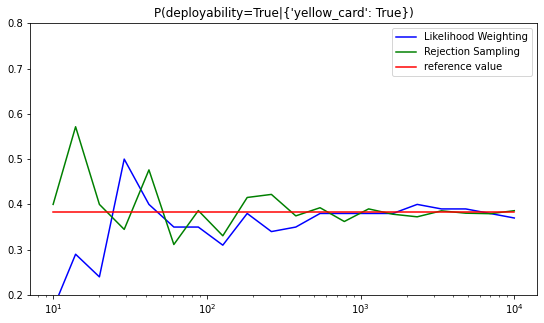

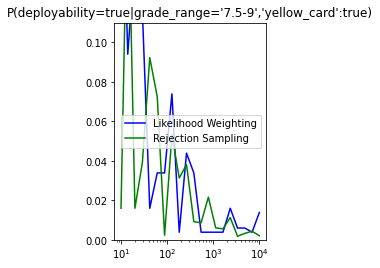

In [24]:
plot_results(results,query_dict,query_var,value)